<img
    style="border-radius: 0.5em;"
    src="https://ucfai.org/groups/core/sp20/reinforcement-learning/banner.png">

<div class="col-12">
    <h1> Training Machines to Learn From Experience </h1>
    <hr>
</div>

<div style="line-height: 2em;">
    <p>by: 
        <a href="https://ucfai.org/authors/danielzgsilva">@danielzgsilva</a>,
        <a href="https://ucfai.org/authors/JarvisEQ">@JarvisEQ</a>and,
        <a href="https://ucfai.org/authors/ionlights">@ionlights</a> on Apr 01, 2020</p>
</div>

In [ ]:
from pathlib import Path

DATA_DIR = Path("/kaggle/input")
if (DATA_DIR / "ucfai-core-sp20-reinforcement-learning").exists():
    DATA_DIR /= "ucfai-core-sp20-reinforcement-learning"
elif DATA_DIR.exists():
    # no-op to keep the proper data path for Kaggle
    pass
else:
    # You'll need to download the data from Kaggle and place it in the `data/`
    #   directory beside this notebook.
    # The data should be here: https://kaggle.com/c/ucfai-core-sp20-reinforcement-learning/data
    DATA_DIR = Path("data")

We'll be using OpenAI's gym library and PyTorch for our reinforcement learning workshop. Naturally, we start off by importing these libraries, as well as a few others.

In [ ]:
import gym
from gym import wrappers

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

import io
import base64
from IPython.display import HTML
from tqdm import tqdm, trange

## OpenAI Gym - Mountain Car 

This is a classic reinforcement learning problem, in which our goal is to create an algorithm that enables a car to climb a steep mountain. 

A key point is that the car's engine is not powerful enough to drive directly up the mountain. Therefore, the car will need to utilize the left side mountain in order to gain enough momemtum to drive up the right side.

![Mountain Car](https://miro.medium.com/proxy/1*nbCSvWmyS_BUDz_WAJyKUw.gif)

In [ ]:
# Making our environment

env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)

## Details

In order to interact with OpenAI's gym environments, there are a few things we need to understand. 

Every environment has what's called an **action space**, or essentially the possible moves our car could make. We make these moves in steps. That is, choose an action, then apply that action, evaluate the results, and so on.

In [3]:
print(env.action_space)

Discrete(3)


As you can see, there are 3 distinct actions we can take at each step. These are: move left, stay still, or move right.

In practice, we apply one of these actions using `env.step()`.

This action would then be applied to the car, resulting in a new **state**. In this Mountain Car example, the car's state is simply made up of its position and velocity. OpenAI likes to call this state an **observation**.

In [4]:
print(env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Box(2,)
[-1.2  -0.07]
[0.6  0.07]


As mentioned previously, the state, or an observation of the environment, consists of the car's position and velocity. This results in a length 2 observation space. The upper and lower bounds of this observation space signifies that the car's minimum and maximum position is -1.2 and 0.6, respectively. Position 0.5 and above signifies success. The cars min and max velocities are -0.7 and 0.7.

`env.step()` also returns a reward, based on the result of the action it received. The reward function for MountainCar is quite simple:
  For each step that the car does not reach the goal (position 0.5), the environment returns a reward of -1.

## Testing with Random Actions

We can now apply what we know about **gym** to see how Mountain Car would do with completely random actions. That is, at each step, we'll randomly select either move right, left, or neither. We'll play 1000 of these random Mountain Car games, each with an arbitrary number of 200 steps per game.

In [ ]:
episodes = 1000
steps = 200
env._max_episode_steps = steps

successes = 0
position_history = []
reward_history = []

In [ ]:
for i in trange(episodes):
    # Initial state
    done = False
    running_reward = 0
    max_position = -0.4
    state = env.reset()

    # Run the episode
    while not done:
        # Select random action
        action = env.action_space.sample()
        
        # Execute action
        state, reward, done, info = env.step(action)

        # Get car's current position and update furthest position for this episode
        current_position = state[0]
        if current_position > max_position:
            max_position = current_position

        # Track reward
        running_reward += reward

    # Document this episodes total reward and furthest position
    reward_history.append(running_reward)
    position_history.append(max_position)

    # Document success if car reached 0.5 or further
    if max_position >= 0.5:
        successes += 1

Furthest Position: -0.18254959181959152


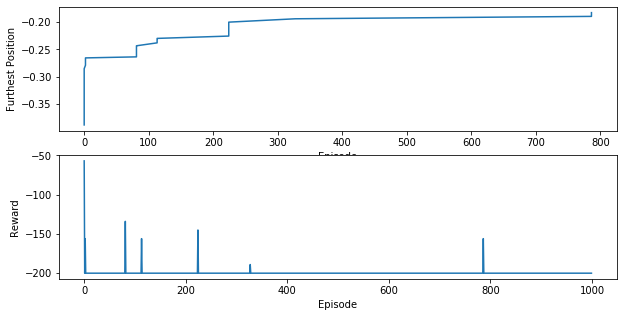

Successful Episodes: 0


In [6]:
print('Successful Episodes: {}'.format(successes))
print('Success Rate: {}%'.format(round((successes/episodes)*100,2)))

plt.figure(1, figsize=[10,5])
plt.subplot(211)

# Calculate and plot moving average of each episodes furthest position
p = pd.Series(position_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.ylabel('Position')
plt.title('Cars Furthest Position')

# Calculate and plot moving average of each episodes total reward
plt.subplot(212)
p = pd.Series(reward_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

We can see above that using random actions doesn't result in a single successful episode of Mountain Car, out of 1000 games. Now let's take a look at how to make our agent smarter.

## Q Learning Algorithm


We'll use Q-Learning, one of the most simple and common reinforcement learning algorithms, to learn a policy for our Mountain Car game. Intuitively, the policy we're learning is essentially a function which can decide what next action to take, given the cars current state, in order to maximize reward.

We'll represent this policy with a simple python dictionary. To do this, we'll first bucketize the mountain car state space.

In [ ]:
pos_space = np.linspace(-1.2, 0.6, 20)
vels_space = np.linspace(-0.07, 0.07, 20)

The below function will take a continuous observation and output the corresponding discrete bucket.

In [ ]:
def get_state(observation):
    pos, vel = observation
    pos_bin = np.digitize(pos, pos_space)
    vel_bin = np.digitize(vel, vels_space)

    return (pos_bin, vel_bin)

We can now create our Q table, containing a key for each state-action pair. Each Q value itself represents the expected reward for taking a certain action from a given state.

In [ ]:
# Create list of possible states
states = []
for pos in range(21):
    for vel in range(21):
        states.append((pos, vel))

# Initialize Q table
Q = {}
for state in states:
    for action in [0,1,2]:
        Q[state, action] = 0

Again, each of these Q values represents the expected reward for taking one of the 3 possible actions from a given state. So, in order to maximize reward while playing the game, at each step, we'll take the action which we predict will give us the most reward. 

To do this, we'll leverage the below function. This outputs the most rewarding action, given the car's current state.

In [ ]:
def max_action(Q, state, actions=[0,1,2]):
    action_choices = np.array([Q[state, a] for a in actions])

    return np.argmax(action_choices)

Finally, we arrive at the Q-learning algorithm. This is what enables the car to truly learn from its experiences and become artificially intelligent.

The Q-Learning algorithm below is used to update our Q table as the car moves about the environment. Everytime we take an action in the environment, we'll update Q based on the reward returned for that action, as well as the maximum future action value one step in the future. 

By updating our Q values with this algorithm, over time, our Q values will become increasingly accurate, eventually becoming quite accurate predictions of the reward that will be returned for taking a certain action from a certain state.

![Q-Learning Algorithm](https://developer.ibm.com/developer/articles/cc-reinforcement-learning-train-software-agent/images/fig03.png)

At this point one might be wondering: "Well if each Q value is initialized to 0, what action do we take to start off?"

This is where **epsilon-greedy action selection** comes into play. In the beginning of the game, when we haven't yet learned anything about the environment, we take totally random actions. This allows the agent to simply explore the environment and slowly learn which actions work well. As we learn more about the environment, and our Q values become more accurate, we can rely on these predictions and only take actions which we know will be rewarding.

This action selection strategy introduces a trade off between **exploring** the environment (taking random actions), and **exploiting** our learned policy (taking the action with the highest Q value). If you read into Reinforcement Learning you'll be sure to hear more about exploration vs exploitation, as its such an integral part of many RL algorithms.

To apply this technique, we use the variable **epsilon**. It's initialized as 1, and can go as low as 0. When epsilon is 1, we take totally random actions. As we play the mountain car game, we'll slowly reduce this number until it reaches 0. At this point, we'll be relying 100% on our Q table to tell us which action to take next.

We'll run this algorithm on 2000 Mountain Car games, and in each game we take 1000 individual steps.

In [ ]:
# Parameters
episodes = 2000
steps = 1000
epsilon = 1
gamma = 0.99
lr = 0.1

env._max_episode_steps = steps

successes = 0
position_history = []
reward_history = []

At this point we're finally ready to train our policy using this Q-Learning algorithm.

In [13]:
for i in range(episodes):
    if i % 100 == 0 and i > 0:
          print('episode ', i, 'score ', running_reward, 'epsilon %.3f' % epsilon)

    # Initial state
    done = False
    running_reward = 0
    max_position = -0.4
    obs = env.reset()
    state = get_state(obs)

    # Run the episode
    while not done:
        # Esilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = max_action(Q, state)
        
        # Execute chosen action
        next_obs, reward, done, info = env.step(action)

        # Get car's current position and update furthest position for this episode
        current_position = next_obs[0]
        if current_position > max_position:
            max_position = current_position

        # Track reward
        running_reward += reward

         # Bucketize the state
        next_state = get_state(next_obs)

        # Select the next best action (used in Q-learning algorithm)
        next_action = max_action(Q, next_state)

         # Update our Q policy with what we learned from the previous state
        Q[state, action] = Q[state, action] + lr*(reward + gamma*Q[next_state, next_action] - Q[state, action])

        state = next_state

    # Document this episodes total reward and furthest position
    reward_history.append(running_reward)
    position_history.append(max_position)

    # Document success if car reached 0.5 or further
    if max_position >= 0.5:
        successes += 1
    
    # Decrease epsilon (lower bounded at 0.01 so theres always some chance of a random action)
    epsilon = epsilon - 2/episodes if epsilon > 0.01 else 0.01

episode  100 score  -1000.0 epsilon 0.900
episode  200 score  -1000.0 epsilon 0.800
episode  300 score  -547.0 epsilon 0.700
episode  400 score  -511.0 epsilon 0.600
episode  500 score  -415.0 epsilon 0.500
episode  600 score  -247.0 epsilon 0.400
episode  700 score  -273.0 epsilon 0.300
episode  800 score  -265.0 epsilon 0.200
episode  900 score  -219.0 epsilon 0.100
episode  1000 score  -192.0 epsilon 0.010
episode  1100 score  -194.0 epsilon 0.010
episode  1200 score  -187.0 epsilon 0.010
episode  1300 score  -178.0 epsilon 0.010
episode  1400 score  -117.0 epsilon 0.010
episode  1500 score  -144.0 epsilon 0.010
episode  1600 score  -219.0 epsilon 0.010
episode  1700 score  -150.0 epsilon 0.010
episode  1800 score  -148.0 epsilon 0.010
episode  1900 score  -151.0 epsilon 0.010


Successful Episodes: 1737
Success Rate: 86.85%


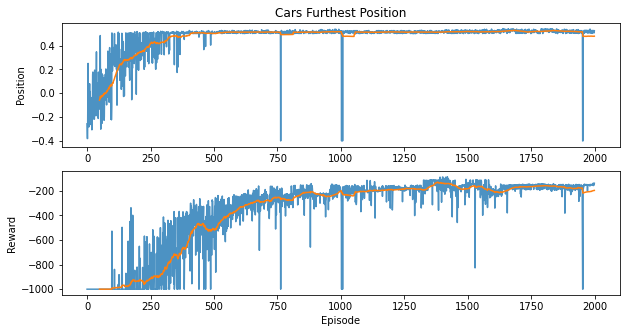

In [14]:
print('Successful Episodes: {}'.format(successes))
print('Success Rate: {}%'.format(round((successes/episodes)*100,2)))

plt.figure(1, figsize=[10,5])
plt.subplot(211)

# Calculate and plot moving average of each episodes furthest position
p = pd.Series(position_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.ylabel('Position')
plt.title('Cars Furthest Position')

# Calculate and plot moving average of each episodes total reward
plt.subplot(212)
p = pd.Series(reward_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

Running the Q-Learning algorithm on 2000 episodes of Mountain Car yields over 1700 successful episodes, or a 86% success rate. We can see that in the first few hundred episodes, the car seems to move a bit randomly at first, although there is certainly evidence of learning. When the car finally reaches the goal for the first time, it is then able to learn a policy which allows it to replicate this success. The car seems to then reach the goal nearly every episode following its first success.

These results are certainly better than using totally random actions, but we could actually do better!

If you can recall, by default, the Mountain Car environment returns a reward of -1 for every step that did not result in success. Start thinking about possible shortcomings of this approach... Is there any information in the car's state that we could advantage of in order to create a better reward function?

## Visualizing the Policy

Now that we've trained a policy, let's take a second to visualize the decisions this policy is making. We can do so by plotting the policy's decisions for each possible combination of position and velocity.

In [ ]:
# List of possible positions
X = np.random.uniform(-1.2, 0.6, 10000)
# List of possible velocities
Y = np.random.uniform(-0.07, 0.07, 10000)

# For each possible state, retreive the most rewarding action and record it
actions = []
for i in range(len(X)):
    state = get_state([X[i], Y[i]])
    action = max_action(Q, state)
    actions.append(action)

actions = pd.Series(actions)
colors = {0:'blue',1:'lime',2:'red'}
colors = actions.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

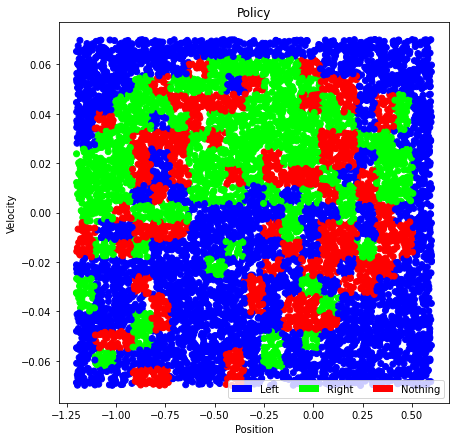

In [16]:
# Visualize the policy

fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=actions)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

We can see that the policy decides to move the car left, *usually*, when the car is moving to the left (negative velocity), and then switches direction to the right when the car is moving to the right. 

This decision process allows the car to take advantage of momentum gained from the left hill. 

However, there seems to be a strange interaction between the car's position and the policy. It seems to slightly favor moving right when the car is further to the left. This proves to be inefficient and inhibits the cars ability to utilize the left hill...

## Improving results

Let's think about why our current reward system might produce sub-optimal results... By default, the gym environment returns a reward of -1 for every step that doesn't result in success. This means the agent is not rewarded at all until it reaches the success point. Even if the car got close or made good progress in the problem, it's still negatively rewarded...

Because the reward stays constant throughout an episode, it is impossible for our policy to improve until the car randomly reaches the top. Earlier, this is why the policy required hundreds of episodes before showing significant improvements.

Now that we understand some of the shortcomings of our current reward system, let's attempt to design something better!



In [ ]:
# With an improved reward function, 1000 episodes with 200 steps/ep should be plenty to learn an effective policy.
episodes = 2000
steps = 1000
epsilon = 1
gamma = 0.99
lr = 0.1

env._max_episode_steps = steps

successes = 0
position_history = []
reward_history = []

Let's all spend a few minutes thinking about what changes or additions to the reward function might improve performance. Implement your ideas into the training block below and test it out!

**Hint:** We know that we're able to retrieve the car's position and velocity from the observation object returned from the environment. Recall that in the observation vector, position is always first, followed by velocity. How could we use this information to improve the reward function? Could we reward the agent for at least moving in the right direction or gaining energy?

In [ ]:
# Reset our Q table
for state in states:
    for action in [0,1,2]:
        Q[state, action] = 0

In [ ]:
for i in range(episodes):
    # Initial state
    done = False
    running_reward = 0
    max_position = -0.4
    obs = env.reset()
    state = get_state(obs)

    # Run the episode
    while not done:
        # Esilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = max_action(Q, state)
        
        # Execute chosen action
        next_obs, reward, done, info = env.step(action)

        # Get car's current position and update furthest position for this episode
        current_position = next_obs[0]
        if current_position > max_position:
            max_position = current_position

        # Make your adjustments or additions to the reward below
        ### BEGIN SOLUTION

        # Reward will now be the total mechanical energy gained from taking an action
        kinetic_before = 0.5 * obs[1] * obs[1]
        kinetic_after = 0.5 * next_obs[1] * next_obs[1]
        
        potential_before = np.sin(3 * obs[0]) * 0.0025
        potential_after = np.sin(3 * next_obs[0]) * 0.0025

        reward = 100*(kinetic_after + potential_after - kinetic_before - potential_before)

        ### END SOLUTION

        # Track reward
        running_reward += reward

         # Bucketize the state
        next_state = get_state(next_obs)

        # Select the next best action (used in Q-learning algorithm)
        next_action = max_action(Q, next_state)

         # Update our Q policy with what we learned from the previous state
        Q[state, action] = Q[state, action] + lr*(reward + gamma*Q[next_state, next_action] - Q[state, action])

        state = next_state
        obs = next_obs

    # Document this episodes total reward and furthest position
    reward_history.append(running_reward)
    position_history.append(max_position)

    # Document success if car reached 0.5 or further
    if max_position >= 0.5:
        successes += 1
    
    # Decrease epsilon (lower bounded at 0.01 so theres always some chance of a random action)
    epsilon = epsilon - 2/episodes if epsilon > 0.01 else 0.01

Successful Episodes: 1792
Success Rate: 89.6%


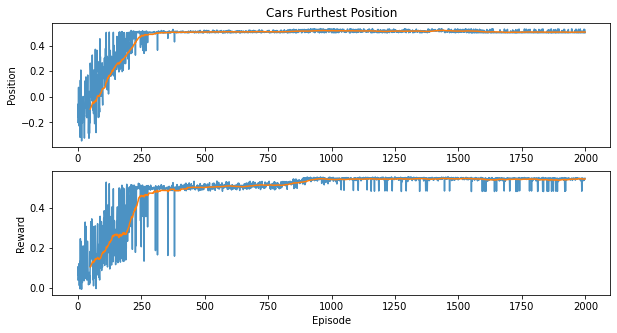

In [20]:
print('Successful Episodes: {}'.format(successes))
print('Success Rate: {}%'.format(round((successes/episodes)*100,2)))

plt.figure(1, figsize=[10,5])
plt.subplot(211)

# Calculate and plot moving average of each episodes furthest position
p = pd.Series(position_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.ylabel('Position')
plt.title('Cars Furthest Position')

# Calculate and plot moving average of each episodes total reward
plt.subplot(212)
p = pd.Series(reward_history)
plt.plot(p, alpha=0.8)
plt.plot(p.rolling(50).mean())
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

As you can see, this simple addition to the reward function results in a slight improvement in performance. The car seems to learn an efficient policy in roughly 300 episodes, and is then able to achieve success in nearly every following episode.

However, these results don't quite capture the true benefit of our new reward function. The improvement will be much more clear when we visualize the policy. This time around, we hope to see a much cleaner and more efficient policy.

![Solved Mountain Car](https://miro.medium.com/max/1202/0*VsDhkvrcaTOc2bwu.gif)

## Visualizing the Improved Policy

In [ ]:
X = np.random.uniform(-1.2, 0.6, 10000)
Y = np.random.uniform(-0.07, 0.07, 10000)

actions = []
for i in range(len(X)):
    state = get_state([X[i], Y[i]])
    action = max_action(Q, state)
    actions.append(action)

actions = pd.Series(actions)
colors = {0:'blue',1:'lime',2:'red'}
colors = actions.apply(lambda x:colors[x])
labels = ['Left','Right','Nothing']

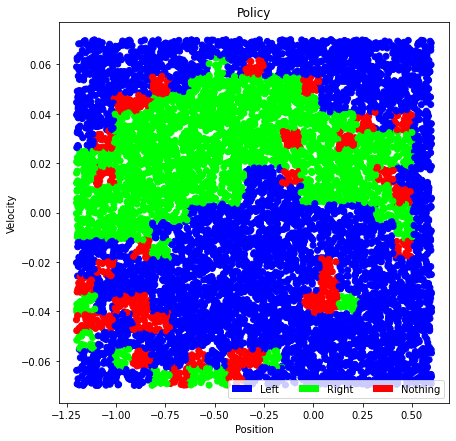

In [22]:
fig = plt.figure(5, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
surf = ax.scatter(X,Y, c=actions)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
for i in range(0,3):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=sorted(colors.unique())[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()

With our improved reward function, the learned policy now seems to be more closely dependent on velocity. It decides to move left when the velocity is negative, and right when velocity is positive. As the results show, this is more effective in solving MountainCar. Additionally, this new reward function simply results in a much cleaner policy, with a stronger more clear relationship between position and velocity.

If you think about it, what this is doing is enabling the car to drive as far up a hill as possible. When momentum fades and the car begins to fall back down the mountain, our policy tells the engine to drive as fast as possible down this hill. After doing this enough times, the car's momentum will carry it over the large hill and past the flag.

![Solved Mountain Car](https://miro.medium.com/max/1202/0*VsDhkvrcaTOc2bwu.gif)
